# SetUp

In [42]:
!pip install seaborn
!pip install scipy

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sp
from scipy.constants import physical_constants

---

# Ecuaciones Físicas

In [21]:
def radial_function(n, l, r, b_r):
    """
    Calcula la parte radial de la función de onda normalizada para el átomo de hidrógeno.

    Args:
        n (int): Número cuántico principal.
        l (int): Número cuántico azimutal.
        r (numpy.ndarray): Coordenada radial.
        b_r (float): Radio de Bohr escalado.

    Returns:
        numpy.ndarray: Función de onda radial normalizada.
    """
    
    laguerre_polynomial = sp.genlaguerre(n - l - 1, 2 * l + 1)
    
    radial_variable = 2 * r / (n * b_r)

    # Factor de normalización
    normalization_factor = np.sqrt(
        ((2 / n * b_r) ** 3 * (sp.factorial(n - l - 1))) /
        (2 * n * (sp.factorial(n + l)))
    )

    # Función radial
    return normalization_factor * np.exp(-radial_variable / 2) * (radial_variable ** l) * laguerre_polynomial(radial_variable)

In [22]:
def angular_function(m, l, theta, phi):
    """
    Calcula la parte angular de la función de onda normalizada para el átomo de hidrógeno.

    Args:
        m (int): Número cuántico magnético.
        l (int): Número cuántico azimutal.
        theta (numpy.ndarray): Ángulo polar.
        phi (int): Ángulo azimutal.

    Returns:
        numpy.ndarray: Componente angular de la función de onda.
    """
    
    # Polinomio de Legendre asociado a m y l
    legendre_polynomial = sp.lpmv(m, l, np.cos(theta))

    # Factor de normalización
    normalization_factor = ((-1) ** m) * np.sqrt(
        ((2 * l + 1) * sp.factorial(l - np.abs(m))) /
        (4 * np.pi * sp.factorial(l + np.abs(m)))
    )

    # Función angular con la fase exponencial
    return normalization_factor * legendre_polynomial * np.real(np.exp(1.j * m * phi))

In [23]:
def compute_wavefunction(n, l, m, b_r_scale_factor):
    """
    Calcula la función de onda normalizada como el producto de sus componentes
    radial y angular.

    Args:
        n (int): Número cuántico principal.
        l (int): Número cuántico azimutal.
        m (int): Número cuántico magnético.
        b_r_scale_factor (float): Factor de escala del radio de Bohr.

    Returns:
        numpy.ndarray: Función de onda.
    """
    
    # Escala el radio de Bohr para una visualización efectiva
    bohr_radius = b_r_scale_factor * physical_constants['Bohr radius'][0] * 1e+12

    # Definir la extensión y resolución de la malla para representar la distribución espacial del electrón
    grid_extent = 480
    grid_resolution = 680
    grid_z = grid_x = np.linspace(-grid_extent, grid_extent, grid_resolution)
    grid_z, grid_x = np.meshgrid(grid_z, grid_x)

    # Usar epsilon para evitar la división por cero durante los cálculos de ángulo
    epsilon = np.finfo(float).eps

    # Ψnlm(r,θ,φ) = Rnl(r).Ylm(θ,φ)
    wavefunction = radial_function(
        n, l, np.sqrt((grid_x ** 2 + grid_z ** 2)), bohr_radius
    ) * angular_function(
        m, l, np.arctan(grid_x / (grid_z + epsilon)), 0
    )
    
    return wavefunction

In [24]:
def compute_probability_density(wavefunction):
    """
    Calcula la densidad de probabilidad de una función de onda dada.

    Args:
        wavefunction (numpy.ndarray): Función de onda.

    Returns:
        numpy.ndarray: Densidad de probabilidad de la función de onda.
    """
    return np.abs(wavefunction) ** 2

---

# Gráficas

In [ ]:
def plot_wf_probability_density(n, l, m, b_r_scale_factor, dark_theme=False, colormap='mako'):
    """
    Grafica la densidad de probabilidad de la función de onda del átomo de hidrógeno 
    para un estado cuántico dado (n,l,m).

    Args:
        n (int): Número cuántico principal, determina el nivel de energía y el tamaño de la órbita.
        l (int): Número cuántico azimutal, define la forma de la órbita.
        m (int): Número cuántico magnético, define la orientación de la órbita.
        b_r_scale_factor (float): Factor de escala del radio de Bohr.
        dark_theme (bool): Si es True, utiliza un fondo oscuro para la gráfica. Por defecto es False.
        colormap (str): Colormap de Seaborn para la gráfica. Por defecto es 'mako'.
    """

    # Validación de los números cuánticos
    if not isinstance(n, int) or n < 1:
        raise ValueError('n debe ser un número entero mayor o igual a 1')
    if not isinstance(l, int) or not (0 <= l < n):
        raise ValueError('l debe ser un número entero tal que 0 <= l < n')
    if not isinstance(m, int) or not (-l <= m <= l):
        raise ValueError('m debe ser un número entero tal que -l <= m <= l')

    # Validación del colormap
    try:
        sns.color_palette(colormap)
    except ValueError:
        raise ValueError(f'{colormap} no es un colormap reconocido por Seaborn.')

    # Configuración de la estética del gráfico utilizando rcParams de matplotlib
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['xtick.major.width'] = 4
    plt.rcParams['ytick.major.width'] = 4
    plt.rcParams['xtick.major.size'] = 15
    plt.rcParams['ytick.major.size'] = 15
    plt.rcParams['xtick.labelsize'] = 30
    plt.rcParams['ytick.labelsize'] = 30
    plt.rcParams['axes.linewidth'] = 4

    # Crear la figura y los ejes para el gráfico
    fig, ax = plt.subplots(figsize=(16, 16.5))
    plt.subplots_adjust(top=0.82, right=0.905, left=-0.1)

    # Calcular y visualizar la densidad de probabilidad de la función de onda
    wavefunction = compute_wavefunction(n, l, m, b_r_scale_factor)
    probability_density = compute_probability_density(wavefunction)
    
    # Transponer la matriz para alinear la representación con la visualización de Matplotlib
    im = ax.imshow(np.sqrt(probability_density).T, cmap=sns.color_palette(colormap, as_cmap=True))

    # Añadir barra de color
    colorbar = plt.colorbar(im, fraction=0.046, pad=0.03)
    colorbar.set_ticks([])

    # Aplicar parámetros del tema oscuro
    if dark_theme:
        theme = 'dark'
        background_color = sorted(
            sns.color_palette(colormap, n_colors=100),
            key=lambda color: 0.2126 * color[0] + 0.7152 * color[1] + 0.0722 * color[2]
        )[0]
        plt.rcParams['text.color'] = '#dfdfdf'
        title_color = '#dfdfdf'
        fig.patch.set_facecolor(background_color)
        colorbar.outline.set_visible(False)
        ax.tick_params(axis='x', colors='#c4c4c4')
        ax.tick_params(axis='y', colors='#c4c4c4')
        for spine in ax.spines.values():
            spine.set_color('#c4c4c4')
    else:  # Aplicar parámetros del tema claro
        theme = 'light'
        plt.rcParams['text.color'] = '#000000'
        title_color = '#000000'
        ax.tick_params(axis='x', colors='#000000')
        ax.tick_params(axis='y', colors='#000000')

    # Añadir título y texto explicativo al gráfico
    ax.set_title('Átomo de Hidrógeno - Densidad Electrónica', 
                 pad=20, fontsize=44, loc='left', color=title_color)
    ax.text(30, 615, r'$({0}, {1}, {2})$'.format(n, l, m), color='#dfdfdf', fontsize=42)
    ax.text(770, 150, 'Distribución de probabilidad del electrón', rotation='vertical', fontsize=30)
    ax.text(705, 700, 'Mayor\nprobabilidad', fontsize=20)
    ax.text(705, -60, 'Menor\nprobabilidad', fontsize=20)
    ax.text(775, 590, '+', fontsize=34)
    ax.text(769, 82, '−', fontsize=34, rotation='vertical')
    ax.invert_yaxis()

    # Crear la carpeta "media" si no existe
    if not os.path.exists('media'):
        os.makedirs('media')

    # Guardar y mostrar la gráfica en la carpeta "media"
    plt.savefig(f'media/({n},{l},{m})[{theme}].png')
    plt.show()

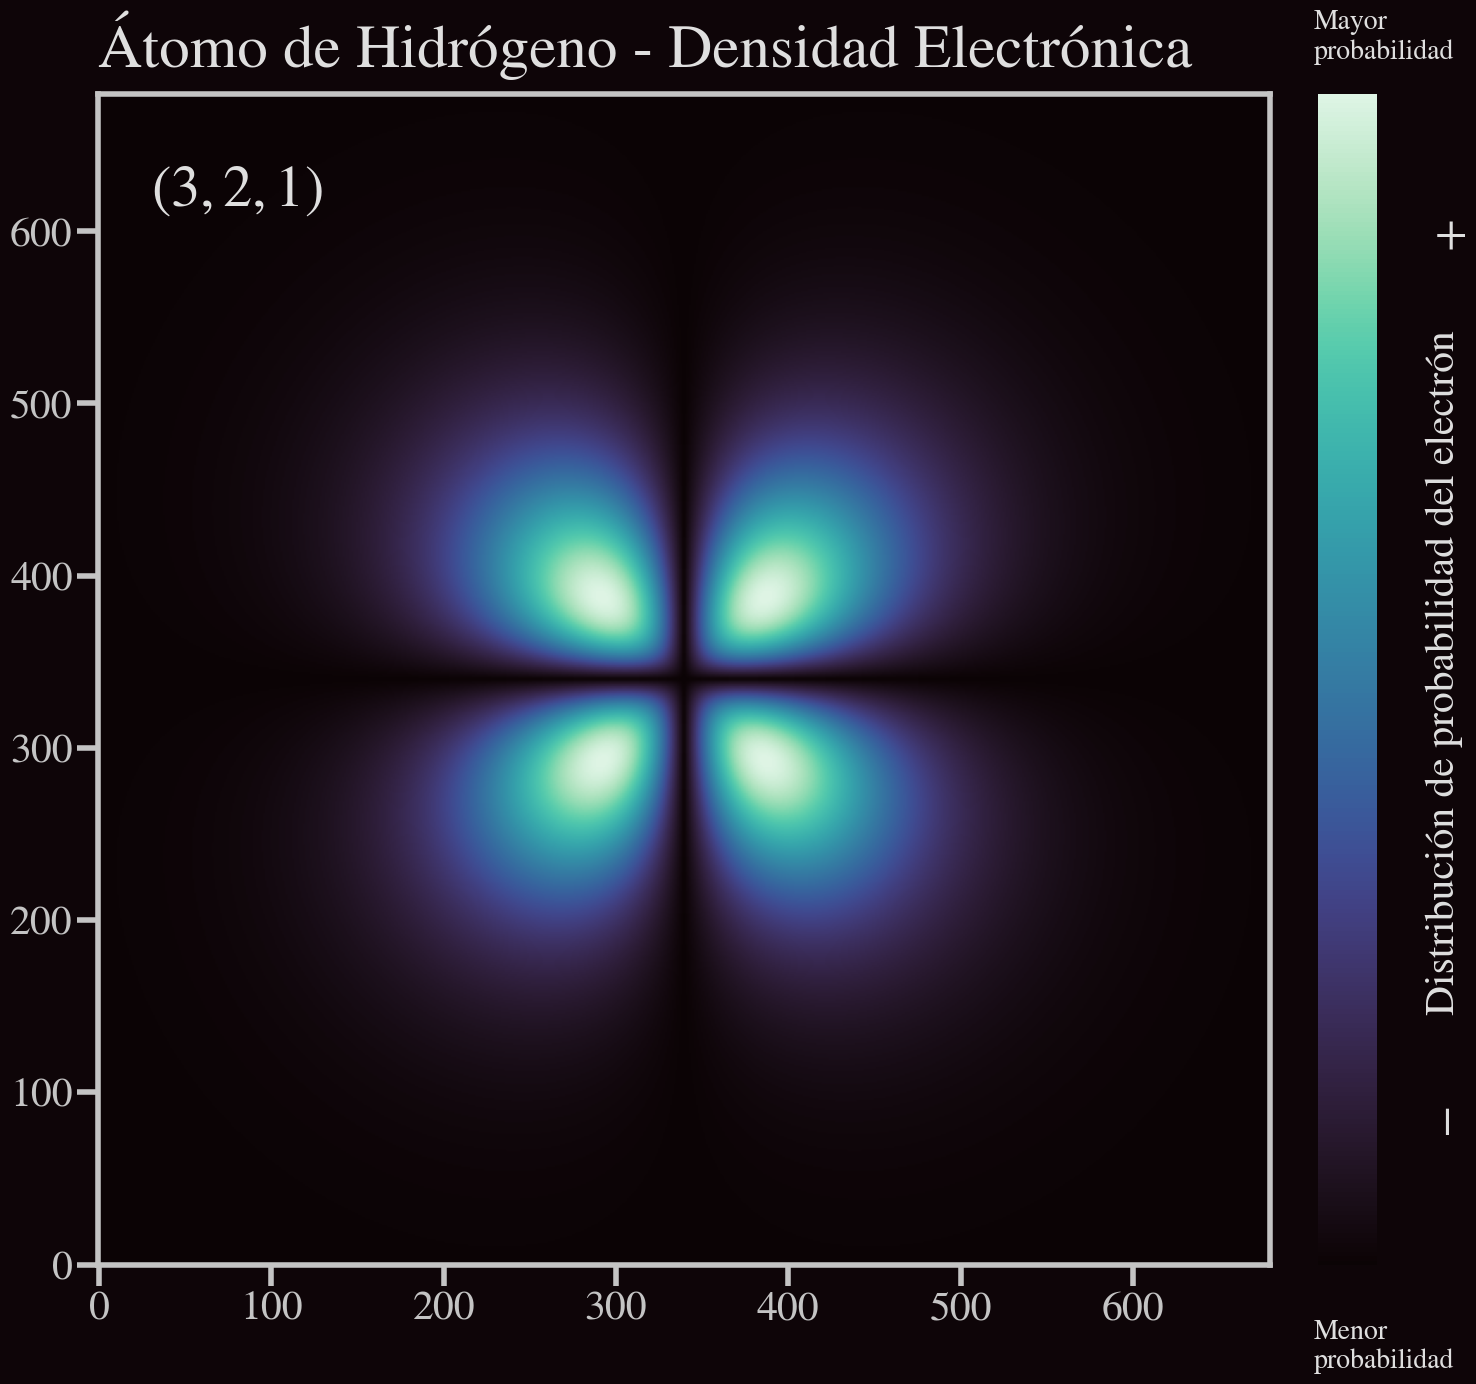

In [51]:
plot_wf_probability_density(3, 2, 1, 0.3, True)

---

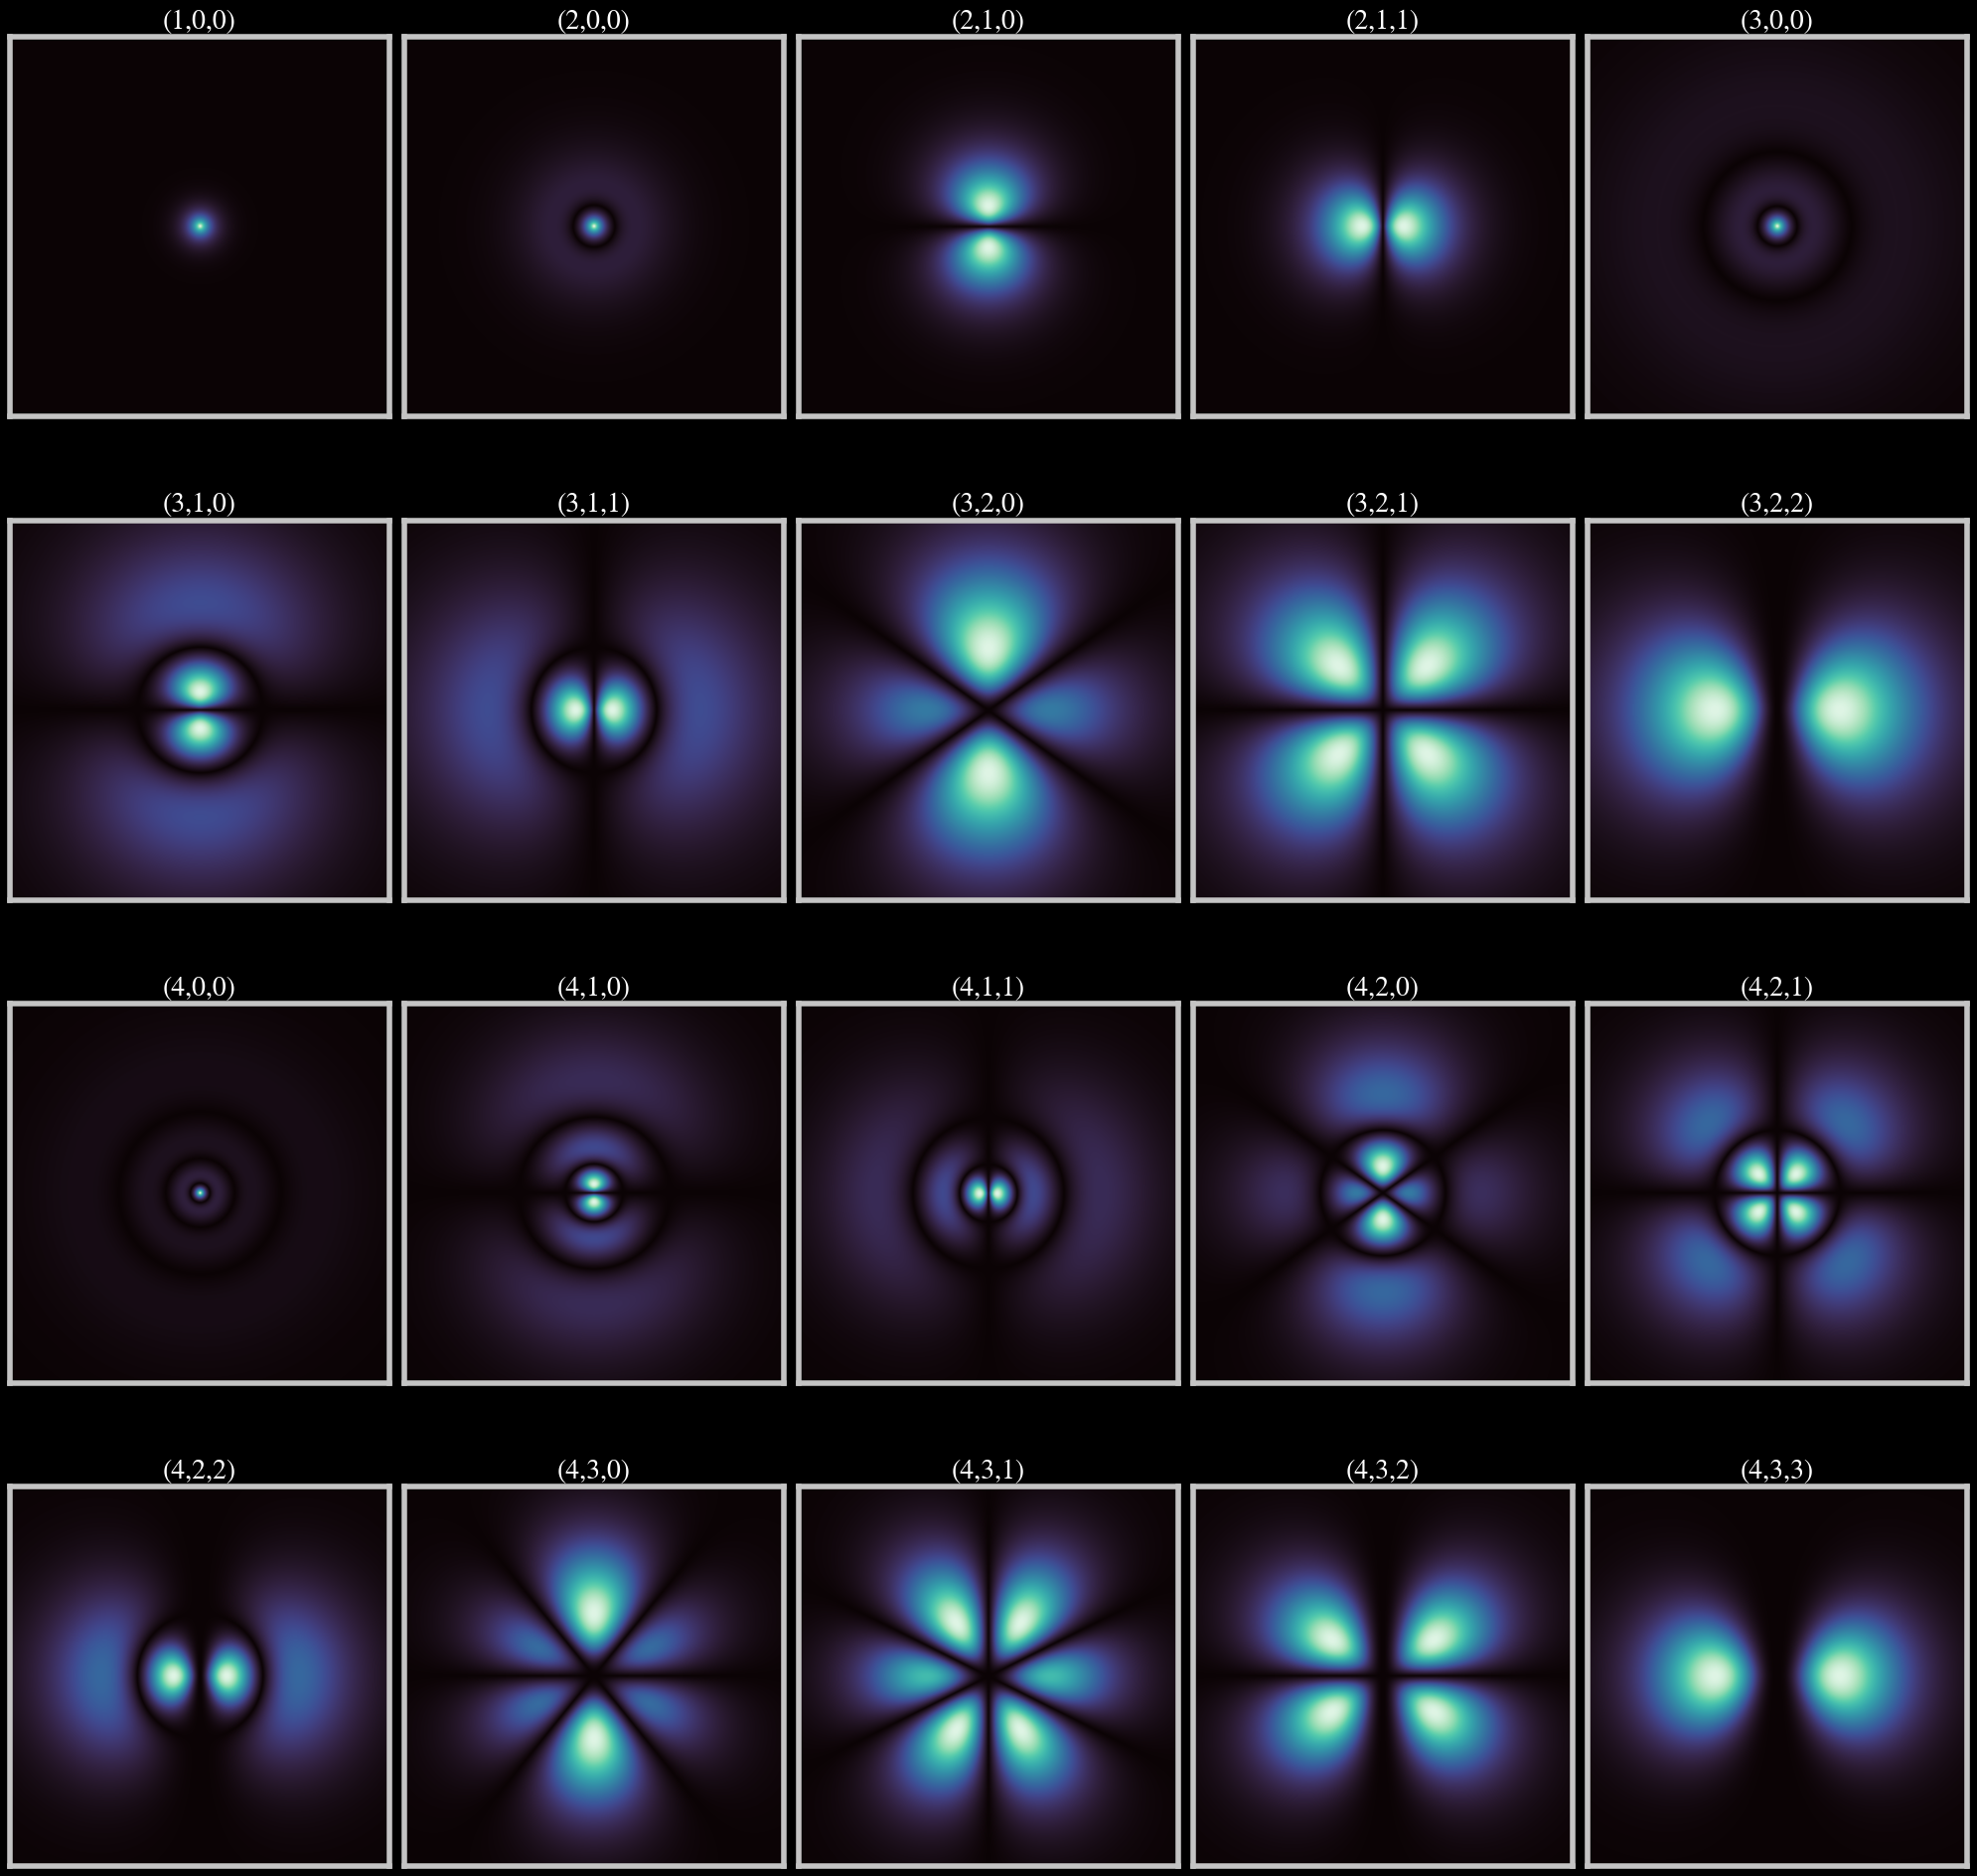

In [56]:
def plot_wf_probability_density(n, l, m, b_r_scale_factor, dark_theme=False, colormap='mako', ax=None):
    """
    Grafica la densidad de probabilidad de la función de onda del átomo de hidrógeno 
    para un estado cuántico dado (n,l,m) en un eje específico (ax).

    Args:
        n (int): Número cuántico principal, determina el nivel de energía y el tamaño de la órbita.
        l (int): Número cuántico azimutal, define la forma de la órbita.
        m (int): Número cuántico magnético, define la orientación de la órbita.
        b_r_scale_factor (float): Factor de escala del radio de Bohr.
        dark_theme (bool): Si es True, utiliza un fondo oscuro para la gráfica. Por defecto es False.
        colormap (str): Colormap de Seaborn para la gráfica. Por defecto es 'mako'.
        ax (matplotlib.axes.Axes): El eje donde se dibujará la gráfica.
    """
    
    # Validación de los números cuánticos
    if not isinstance(n, int) or n < 1:
        raise ValueError('n debe ser un número entero mayor o igual a 1')
    if not isinstance(l, int) or not (0 <= l < n):
        raise ValueError('l debe ser un número entero tal que 0 <= l < n')
    if not isinstance(m, int) or not (-l <= m <= l):
        raise ValueError('m debe ser un número entero tal que -l <= m <= l')

    # Validación del colormap
    try:
        sns.color_palette(colormap)
    except ValueError:
        raise ValueError(f'{colormap} no es un colormap reconocido por Seaborn.')

    # Configuración de la estética del gráfico utilizando rcParams de matplotlib
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['xtick.major.width'] = 4
    plt.rcParams['ytick.major.width'] = 4
    plt.rcParams['xtick.major.size'] = 15
    plt.rcParams['ytick.major.size'] = 15
    plt.rcParams['xtick.labelsize'] = 30
    plt.rcParams['ytick.labelsize'] = 30
    plt.rcParams['axes.linewidth'] = 4

    # Calcular y visualizar la densidad de probabilidad de la función de onda
    wavefunction = compute_wavefunction(n, l, m, b_r_scale_factor)
    probability_density = compute_probability_density(wavefunction)
    
    # Transponer la matriz para alinear la representación con la visualización de Matplotlib
    im = ax.imshow(np.sqrt(probability_density).T, cmap=sns.color_palette(colormap, as_cmap=True))

    # Aplicar parámetros del tema oscuro
    if dark_theme:
        background_color = sorted(
            sns.color_palette(colormap, n_colors=100),
            key=lambda color: 0.2126 * color[0] + 0.7152 * color[1] + 0.0722 * color[2]
        )[0]
        ax.tick_params(axis='x', colors='#c4c4c4')
        ax.tick_params(axis='y', colors='#c4c4c4')
        for spine in ax.spines.values():
            spine.set_color('#c4c4c4')
    else:
        ax.tick_params(axis='x', colors='#000000')
        ax.tick_params(axis='y', colors='#000000')

    # Título de cada subgráfico (número cuántico)
    ax.set_title(f'({n},{l},{m})', fontsize=20, color='white')

    # Quitar etiquetas de los ejes
    ax.set_xticks([])
    ax.set_yticks([])

def plot_all_hydrogen_states(b_r_scale_factor, dark_theme=False, colormap='mako'):
    """
    Genera las gráficas de la densidad de probabilidad de la función de onda para 
    todos los posibles estados cuánticos del átomo de hidrógeno, mostrando una tabla de 4x5.
    
    Args:
        b_r_scale_factor (float): Factor de escala del radio de Bohr.
        dark_theme (bool): Si es True, utiliza un fondo oscuro para la gráfica. Por defecto es False.
        colormap (str): Colormap de Seaborn para la gráfica. Por defecto es 'mako'.
    """
    
    # Crear una figura con subgráficas en una cuadrícula de 4x5
    fig, axs = plt.subplots(4, 5, figsize=(20, 20), facecolor='black')
    
    # Definir el rango de números cuánticos
    max_n = 4
    ax_idx = 0  # Índice para recorrer las subgráficas
    for n in range(1, max_n + 1):
        if n == 4:
            b_r_scale_factor /= 2  # Reducir el factor de escala cuando n = 4
        
        for l in range(n):
            for m in range(0, l + 1):
                row, col = divmod(ax_idx, 5)  # Calcular la fila y columna para el gráfico
                ax = axs[row, col]
                plot_wf_probability_density(n, l, m, b_r_scale_factor, dark_theme, colormap, ax)
                ax_idx += 1  # Avanzar al siguiente gráfico
    

    # Crear la carpeta "media" si no existe
    if not os.path.exists('media'):
        os.makedirs('media')

    # Ajustar el diseño para evitar solapamientos
    plt.tight_layout()
    
    # Guardar y mostrar la gráfica en la carpeta "media"
    plt.savefig(f'media/all_states.png')
    plt.show()

# Llamar a la función para graficar todos los estados en una tabla de 4x5
plot_all_hydrogen_states(b_r_scale_factor=0.5, dark_theme=True, colormap='mako')